In [246]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../')
import pandas as pd
from src.gpt_prompt import get_sentiment_general, get_sentiment_general_parallel, get_risk_score
import datetime

In [247]:
df_news = pd.read_csv("../data/news_apple_2022.csv", index_col=0)
df_price = pd.read_csv("../data/price_apple_2022.csv", index_col=0)
df_news["date"] = pd.to_datetime(df_news['date'])
df_price["date"] = pd.to_datetime(df_price['date'])
print(df_news.head())
print(df_price.head())

                 date                                               news
0 2022-01-01 00:32:44  I actually lost weight this holiday season — t...
1 2022-01-01 00:52:34  January Dogs Of The Dow Need A PullbackThirty-...
2 2022-01-01 01:04:02  I switched from Android to iPhone — here's wha...
3 2022-01-01 01:36:26  365 Inspirational Quotes for 2022Inspiring, po...
4 2022-01-01 02:06:21  Is Fitbit Premium worth it? Here's the pros an...
                 date       price
0 2022-01-03 09:31:00  175.826576
1 2022-01-03 09:32:00  176.596792
2 2022-01-03 09:33:00  176.636290
3 2022-01-03 09:34:00  176.776509
4 2022-01-03 09:35:00  176.705412


In [248]:
df_score = pd.read_csv("../data/news_score_apple_2022_3.csv", index_col=0)
df_score = df_score[["date", "score"]]
df_score["date"] = pd.to_datetime(df_score['date'])

In [249]:
date_price_dict = df_price.set_index('date')['price'].to_dict()
# date_price_dict

In [250]:
def find_whole_minute_time_after_n_minutes(time, n):
    new_time = time + pd.Timedelta(minutes=n)
    if new_time.second > 0:
        new_time += pd.Timedelta(minutes=1)
        new_time = new_time.replace(second=0, microsecond=0)
    return new_time

In [251]:
df_news.shape

(43832, 2)

In [252]:

columns = ["price_now", "price_in5", "price_in10", "price_in30", "price_in60"]
deltas = [0, 5, 10, 30, 60]
pd_price = np.zeros((df_news.shape[0], 5))

for i in range(df_news.shape[0]):
    time = df_news["date"][i]
    for j in range(5):
        delta = deltas[j]
        new_time = find_whole_minute_time_after_n_minutes(time, delta)
        if new_time in date_price_dict:
            pd_price[i, j] = date_price_dict[new_time]

In [253]:
pd_price = pd.DataFrame(pd_price, columns=columns)
result_df = pd.concat([df_news, pd_price], axis=1)

In [254]:
result_df.replace(0, pd.NA, inplace=True)
result_df = result_df.merge(df_score, on='date', how='left')
result_df["score"] = result_df["score"].astype(float)
result_df = result_df.dropna()



return_cols = ["return_in5", "return_in10", "return_in20", "return_in60"]
price_cols = ["price_in5", "price_in10", "price_in30", "price_in60"]

for i in range(4):
    result_df[return_cols[i]] = (result_df[price_cols[i]] - result_df["price_now"]) / result_df["price_now"]
    result_df[return_cols[i]] = result_df[return_cols[i]].astype(float)
for col in price_cols:
    result_df.drop(col, axis=1, inplace=True)
result_df

,date,news,price_now,score,return_in5,return_in10,return_in20,return_in60
122,2022-01-03 10:16:38,Wacom's One 13-inch drawing tablet upgrades yo...,178.788946,1.0,-0.002872,-0.001105,0.000387,-0.001491
132,2022-01-03 11:13:34,Roblox And The Sentiment MonsterThe price acti...,178.611204,0.0,0.000332,0.002267,0.004036,0.002101
142,2022-01-03 11:39:26,Apple’s 2022 hardware roadmap reportedly inclu...,178.956814,1.0,0.001379,0.002152,0.000386,0.003200
152,2022-01-03 12:34:59,One-year of the latest virtual Parallels Deskt...,179.38142,1.0,0.000826,0.002037,0.000881,0.003413
162,2022-01-03 13:45:18,Here's Why Momentum Investors Will Love Apple ...,180.556494,1.0,-0.001477,-0.001531,-0.004074,-0.003664
...,...,...,...,...,...,...,...,...
39652,2022-11-23 13:04:49,iCloud for Windows Users Report Receiving Rand...,148.749752,-1.0,0.000067,-0.000601,0.002804,0.009748
39662,2022-11-23 14:22:29,Seek Active Tech Exposure in Machine Learning ...,149.891918,1.0,0.001789,-0.000199,0.000861,0.002120
39862,2022-11-25 10:39:40,Black Friday Started Strong. Four Reasons It M...,147.220242,1.0,-0.000067,-0.000270,-0.000439,-0.003845
39872,2022-11-25 11:19:21,Apple weighs on Dow Jones Industrial Average; ...,147.115958,-1.0,-0.001148,-0.002025,-0.001586,-0.001181


In [255]:
result_df = result_df.dropna()

In [256]:
result_df.describe(include='all')

/var/folders/v0/_fszh3l96cz8c79p9psn63y80000gn/T/ipykernel_1782/3235814888.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  result_df.describe(include='all')


,date,news,price_now,score,return_in5,return_in10,return_in20,return_in60
count,1295,1295,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000
unique,1293,1290,1237.000000,NaN,NaN,NaN,NaN,NaN
top,2022-11-14 11:02:40,Resumen: Clarius recibe la certificacin del ma...,146.168556,NaN,NaN,NaN,NaN,NaN
freq,2,2,3.000000,NaN,NaN,NaN,NaN,NaN
first,2022-01-03 10:16:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2022-11-25 11:57:29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,0.486486,0.000040,0.000049,0.000245,0.000147
std,NaN,NaN,NaN,0.759033,0.002015,0.002944,0.004880,0.006465
min,NaN,NaN,NaN,-1.000000,-0.012320,-0.026658,-0.022939,-0.030785
25%,NaN,NaN,NaN,0.000000,-0.000966,-0.001529,-0.002503,-0.003411


In [257]:
result_df.dtypes

date           datetime64[ns]
news                   object
price_now              object
score                 float64
return_in5            float64
return_in10           float64
return_in20           float64
return_in60           float64
dtype: object

In [262]:
correlation_matrix = result_df[["score", 'return_in5', 'return_in10', 'return_in20', 'return_in60']].corr()

In [263]:
correlation_matrix

,score,return_in5,return_in10,return_in20,return_in60
score,1.000000,0.009397,-0.003751,-0.012066,-0.010433
return_in5,0.009397,1.000000,0.728678,0.501438,0.381481
return_in10,-0.003751,0.728678,1.000000,0.639652,0.467117
return_in20,-0.012066,0.501438,0.639652,1.000000,0.733615
return_in60,-0.010433,0.381481,0.467117,0.733615,1.000000


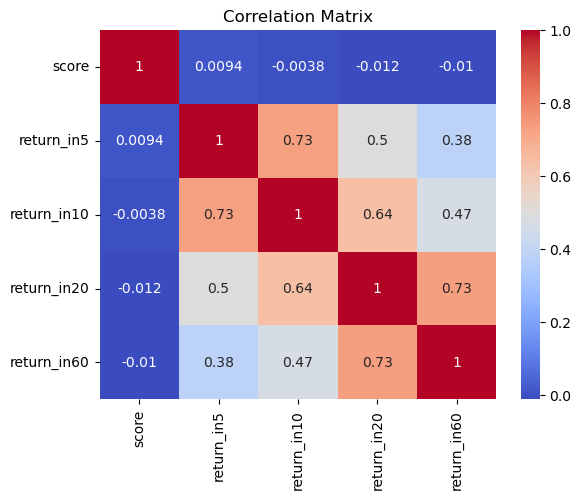

In [264]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

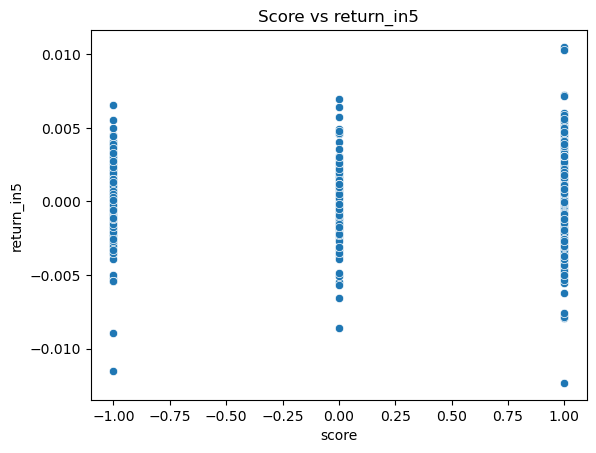

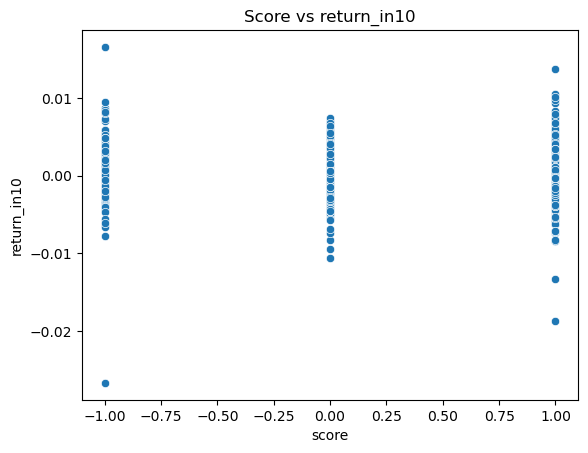

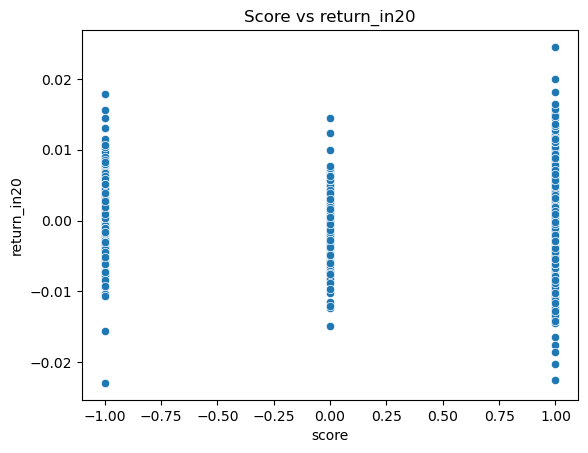

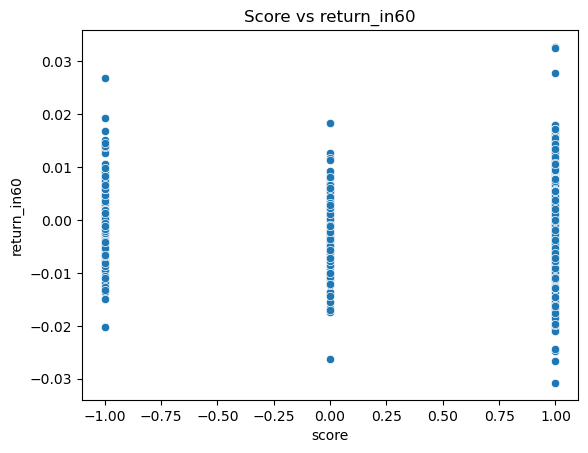

In [265]:
for return_col in ['return_in5', 'return_in10', 'return_in20', 'return_in60']:
    sns.scatterplot(x='score', y=return_col, data=df)
    plt.title(f'Score vs {return_col}')
    plt.show()

In [278]:
np.array(result_df[["return_in5", "return_in10","return_in20","return_in60"]]).shape

(1295, 4)

In [279]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
X = np.array(result_df["score"]).reshape(-1,1)
y = np.array(result_df[["return_in5", "return_in10","return_in20","return_in60"]])
lr.fit(X, y)

LinearRegression()

In [280]:
lr.coef_

array([[ 2.49438278e-05],
       [-1.45494302e-05],
       [-7.75785446e-05],
       [-8.88627389e-05]])